In [48]:
import pandas as pd
import numpy as np
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
import json
from datetime import datetime
import random

Using data from GZD-5.

In [49]:
# General path to data and other files needed
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/'

In [50]:
df = pd.read_csv(path + 'gz_decals_volunteers_5.csv')

# Filter out rows with too few votes to ensure reliability
df = df[df['smooth-or-featured_total-votes'] > 5]

# Printing all label columns to understand the structure of the DataFrame
print("Label columns in the DataFrame:")
label_columns = [col for col in df.columns if col.endswith('debiased')]
print(label_columns)

Label columns in the DataFrame:
['smooth-or-featured_smooth_debiased', 'smooth-or-featured_featured-or-disk_debiased', 'smooth-or-featured_artifact_debiased', 'disk-edge-on_yes_debiased', 'disk-edge-on_no_debiased', 'has-spiral-arms_yes_debiased', 'has-spiral-arms_no_debiased', 'bar_strong_debiased', 'bar_weak_debiased', 'bar_no_debiased', 'bulge-size_dominant_debiased', 'bulge-size_large_debiased', 'bulge-size_moderate_debiased', 'bulge-size_small_debiased', 'bulge-size_none_debiased', 'how-rounded_round_debiased', 'how-rounded_in-between_debiased', 'how-rounded_cigar-shaped_debiased', 'edge-on-bulge_boxy_debiased', 'edge-on-bulge_none_debiased', 'edge-on-bulge_rounded_debiased', 'spiral-winding_tight_debiased', 'spiral-winding_medium_debiased', 'spiral-winding_loose_debiased', 'spiral-arm-count_1_debiased', 'spiral-arm-count_2_debiased', 'spiral-arm-count_3_debiased', 'spiral-arm-count_4_debiased', 'spiral-arm-count_more-than-4_debiased', 'spiral-arm-count_cant-tell_debiased', 'mergi

Treating all 20+ answers as independent multi-label targets is statistically misleading!!

In [51]:
# Selecting the relevant columns (at least for now)
# label_cols = [
#     'smooth-or-featured_smooth_debiased',
#     'smooth-or-featured_featured-or-disk_debiased',
#     'smooth-or-featured_artifact_debiased',
#     'disk-edge-on_yes_debiased',
#     'disk-edge-on_no_debiased',
#     'bar_strong_debiased',
#     'bar_weak_debiased',
#     'bar_no_debiased', 
#     'has-spiral-arms_yes_debiased',
#     'has-spiral-arms_no_debiased'
# ]

label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'smooth-or-featured_artifact',
    'disk-edge-on_yes',
    'disk-edge-on_no',
    'bar_strong',
    'bar_weak',
    'bar_no', 
    'has-spiral-arms_yes',
    'has-spiral-arms_no'
]

df_labels = df[['iauname', 'png_loc'] + label_cols].copy()          # Copying the relevant columns to a new DataFrame including the image name and location

# Cleaning the data, i.e., removing NaN values in the label columns - this ensures that we only keep rows with valid labels and can therefore actually use the data for training
df_clean = df_labels.dropna(subset = label_cols).reset_index(drop = True)

# ---------- Normalizing data ----------

# Inspecting the first few rows of the DataFrame
#print(df_clean.head())

In [52]:
# Printing the number of images in the DataFrame
print(f"Number of images in the DataFrame: {len(df_clean)}")

print("Label columns after normalization:")
# Printing the normalized label columns
for label in label_cols:
    print(f"{label}: {df_clean[label].unique()}")  # Printing unique values to check normalization

# Cheking if they add up to 1
print("Checking if the labels add up to 1 for each image:")
print((df_clean[label_cols].sum(axis=1) == 1).all())  # Should return True if all rows sum to 1

Number of images in the DataFrame: 101631
Label columns after normalization:
smooth-or-featured_smooth: [ 57  33   2  14   8  21   5   3   0   4   7  16  25  19  27  34  30  11
  31  26  28   1   9  17  35  44  32  18  10  20   6  23  12  22  72  81
  15  24  29  60  73  38  55  13  64  51  62  46  45  58  43  37  39  74
  68  71  76  56  36  49  53  70  50  59 142  65  41  75  61  66  80  47
  40  54  42  86  69  78  48  67  52  63 129  84  79 146 145  94  87  82
  77 108  85 107  91 160 122 130 220  83 184 103  88 123 109 100  97  90
  92  95  99 124 189 168 196 110 162 201 170 179 144 215 112 113 165 104
 111]
smooth-or-featured_featured-or-disk: [ 23   2   6  18  29  31  37  39  24  25  11   1  17   7   3  20   5  12
  51   4  10  22  75  35  30   0  50  19   8   9  33  52  32  15  27  16
  26  34  21  13  28  14  43  42  72  36  57  49  40  81  60  41  74  46
  71  38  66  91 104  64  84  90  67  76  77  70  54  55  56  61  45  58
  47  82  78  73  59  80  69  53  68  85  44  48  

In [53]:
# Getting the image data 
path_images = path + 'gz_decals_dr5_png_part1'

""" The folder contains more folders, each with a set of images. The names of the images correspond to the 'iauname' in the DataFrame. """

# Step 1: Recursively collect all image file paths
all_image_paths = glob(os.path.join(path_images, '**', '*.png'), recursive = True)

# Step 2: Create a lookup dict: iauname -> full path
# Assumes filenames are like 'J123456.78+123456.7.png'
iauname_to_path = {
    os.path.splitext(os.path.basename(png_path))[0]: png_path
    for png_path in all_image_paths
}
# Step 3: Create a new column in your clean DataFrame with the full path
df_clean['full_image_path'] = df_clean['iauname'].map(iauname_to_path)

# Step 4: Drop any rows where the image file wasn't found
df_clean = df_clean.dropna(subset = ['full_image_path']).reset_index(drop = True)

# Inspecting the DataFrame after adding the image paths
#print(df_clean.head())

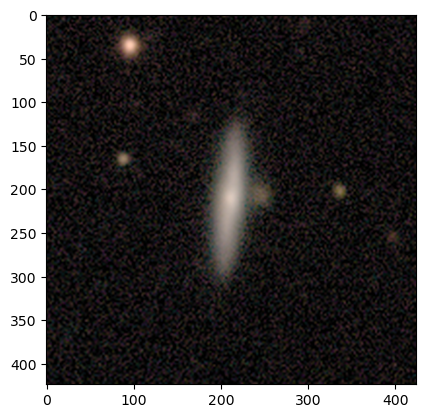

In [54]:
# Plotting one image to test if we can load it correctly
first_image_path = df_clean['full_image_path'].iloc[0]
image = Image.open(first_image_path)
plt.imshow(image)

Loading and plotting the images work - so far so good! Data seems to be ready. 

In [55]:
# Splitting the dataset into training, validation, and test sets
df_train, df_val = train_test_split(df_clean, test_size = 0.2, random_state = 42)

# Importing the validation set
path_val = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/validation_galaxies.csv'

df_val_1 = pd.read_csv(path_val)          

In [63]:
# Step 1: Recursively find all PNG files
all_image_paths = glob(os.path.join(path_images, '**', '*.png'), recursive=True)

# Step 2: Create mapping from iauname → full image path
iauname_to_path = {
    os.path.splitext(os.path.basename(png_path))[0]: png_path
    for png_path in all_image_paths
}

# Step 3: Keep only galaxies in df_val that are in df_val_1
df_val = df_val[df_val['iauname'].isin(df_val_1['iauname'])].reset_index(drop=True)

# Step 4: Find additional galaxies present in df_val_1 but not in df_val
df_val_additional = df_val_1[~df_val_1['iauname'].isin(df_val['iauname'])].reset_index(drop=True)

# Step 5: Map image paths using iauname_to_path for both sets
df_val['full_image_path'] = df_val['iauname'].map(iauname_to_path)
df_val_additional['full_image_path'] = df_val_additional['iauname'].map(iauname_to_path)

# Step 6: Drop any galaxies with missing image paths
df_val = df_val.dropna(subset=['full_image_path']).reset_index(drop=True)
df_val_additional = df_val_additional.dropna(subset=['full_image_path']).reset_index(drop=True)

# Step 7: Concatenate both sets and drop any duplicates
df_val = pd.concat([df_val, df_val_additional], ignore_index=True)
df_val = df_val.drop_duplicates(subset='iauname').reset_index(drop=True)

# Optional: Sanity check — how many files are missing on disk?
missing_files = df_val['full_image_path'].apply(lambda p: not os.path.exists(p)).sum()
print(f"Missing files on disk: {missing_files}")


Missing files on disk: 0


In [64]:
# Cheking how many galaxies are in the training and validation sets
print(f"Number of galaxies in training set: {len(df_train)}")
print(f"Number of galaxies in validation set: {len(df_val)} -- (there should be {len(df_val_1)})")

Number of galaxies in training set: 21141
Number of galaxies in validation set: 3758 -- (there should be 3758)


In [65]:
# Printing a path for a galaxy in the validation set to check if it works
print(f"Path for a galaxy in the validation set: {df_val['full_image_path'].iloc[0]}")

Path for a galaxy in the validation set: /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/gz_decals_dr5_png_part1/J002/J002721.87+000837.4.png


In [39]:
# Saving the names of galaxies in validation set to a csv file
#df_val_names = df_val[['iauname']]
#df_val_names.to_csv('/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/validation_galaxies.csv', index = False)

In [69]:
# Creating DataLoaders for each set
sys.path.append("/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla")

from galaxy_dataset import GalaxyDataset

train_dataset = GalaxyDataset(df_train, label_cols)
val_dataset = GalaxyDataset(df_val, label_cols)

""" A DataLoader is used to load the dataset in batches, which is useful for training models in PyTorch. The DataLoader will handle shuffling and parallel loading of the data. """

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 9, persistent_workers = True)                  
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 9, persistent_workers = True)

Now we are ready to build a model. We start with a basic convolutional neural network (CNN) in PyTorch for multi-label classification of the galaxy morphology based on the image input. We have the following: 
- Input size: 224x224 RBG images
- Output: Multi-label

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
# Defining a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_outputs = 8):                                        # Initialize the CNN with a specified number of output classes (default is 8)

        super(SimpleCNN, self).__init__()                                       # Initialize the parent class 

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)             # First convolutional layer with 3 input channels (RGB), 16 output channels, and a kernel size of 3
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)            # Second convolutional layer with 16 input channels and 32 output channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)            # Third convolutional layer with 32 input channels and 64 output channels

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)                   # Max pooling layer to reduce spatial dimensions 
        self.dropout = nn.Dropout(0.5)                                          # Dropout layer to prevent overfitting - randomly sets 50% of the input units to 0 during training

        self.fc1 = nn.Linear(64 * 28 * 28, 256)                                 # Fully connected layer with input size based on the output of the last convolutional layer and 256 output units
        self.fc2 = nn.Linear(256, num_outputs)                                  # Second fully connected layer with 256 input units and output size equal to the number of labels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                    # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))                                    # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv3(x)))                                    # Apply third convolution, ReLU activation, and max pooling

        x = x.view(x.size(0), -1)                                                # Flatten the tensor for the fully connected layers
        x = F.relu(self.fc1(x))                                                  # Apply first fully connected layer with ReLU activation
        x = self.dropout(x)                                                      # Apply dropout
        x = self.fc2(x)                                                          # Apply second fully connected layer

        return x                                                                 # Return the output logits

In [16]:
class UpgradedCNN(nn.Module):
    def __init__(self, num_outputs=8):
        super(UpgradedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.4)
        )

        # After 4 pooling layers from 224x224 input → 224 / 2⁴ = 14
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Ready for training! We will use PyTorch Lightning.

In [17]:
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping

In [18]:
# Wrapping the model in a PyTorch Lightning module
class LitGalaxyModel(L.LightningModule):
    def __init__(self, model, criterion, learning_rate = 1e-4):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.save_hyperparameters(ignore = ['model', 'criterion'])

        # Add lists to store loss values
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        self.train_losses.append(loss.item())  # <-- Save the loss
        self.log('train_loss', loss, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        self.val_losses.append(loss.item())  # <-- Save the loss
        self.log('val_loss', loss, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr = self.hparams.learning_rate)

In [19]:
# Creating the model, loss function, and PyTorch Lightning module
lit_model = LitGalaxyModel(model = SimpleCNN(num_outputs = len(label_cols)),
                           criterion = nn.BCEWithLogitsLoss(),  # Binary Cross-Entropy Loss for multi-label classification
                           learning_rate = 1e-4)

lit_model_2 = LitGalaxyModel(model = UpgradedCNN(num_outputs = len(label_cols)),
                            criterion = nn.BCEWithLogitsLoss(),  # Binary Cross-Entropy Loss for multi-label classification
                            learning_rate = 1e-4)

In [147]:
# Creating the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs = 15,             # Set the number of epochs for training
    accelerator = 'cpu',
    enable_progress_bar = True,  # Enable progress bar
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [148]:
# Training the model
trainer.fit(
    model = lit_model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader
)

"""
NOTE TO SELF:
Epoch 0 is a warm-up epoch, so the first training step is not counted in the progress bar. The training loss is logged, but the validation loss is not logged until the first epoch is completed. 
The epoch is a sanity check to ensure that the model can run through one full pass of the training data without errors.
"""


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SimpleCNN         | 12.9 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.486    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


'\nNOTE TO SELF:\nEpoch 0 is a warm-up epoch, so the first training step is not counted in the progress bar. The training loss is logged, but the validation loss is not logged until the first epoch is completed. \nThe epoch is a sanity check to ensure that the model can run through one full pass of the training data without errors.\n'

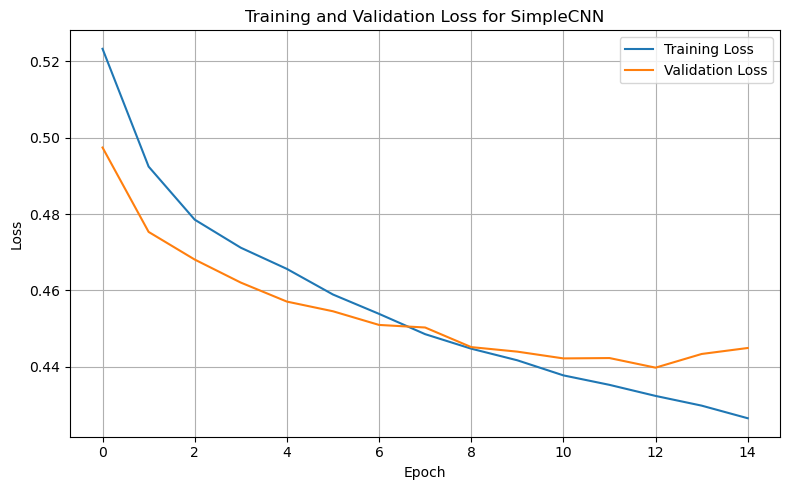

In [149]:
# Group losses by epoch
def average_by_epoch(losses, num_epochs, batches_per_epoch):
    return [
        sum(losses[i*batches_per_epoch:(i+1)*batches_per_epoch]) / batches_per_epoch
        for i in range(num_epochs)
    ]

num_epochs = 15
batches_per_epoch_train = len(train_loader)
batches_per_epoch_val = len(val_loader)
model_name = ['SimpleCNN', 'UpgradedCNN']

train_loss_per_epoch = average_by_epoch(lit_model.train_losses, num_epochs, batches_per_epoch_train)
val_loss_per_epoch = average_by_epoch(lit_model.val_losses, num_epochs, batches_per_epoch_val)

plt.figure(figsize = (8, 5))
plt.plot(train_loss_per_epoch, label = 'Training Loss')
plt.plot(val_loss_per_epoch, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss for {model_name[0]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
# Saving the loss and validation loss to a CSV file
loss_data = {
    'epoch': list(range(1, num_epochs + 1)),
    'train_loss': train_loss_per_epoch,
    'val_loss': val_loss_per_epoch
}

path_loss = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla'
loss_df = pd.DataFrame(loss_data)
loss_df.to_csv(os.path.join(path_loss, 'losses_5.csv'), index = False)

In [19]:
# Evaluatinf the model on the validation set
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(model.device)
            labels = labels.to(model.device).int()                                                                  # Ensure labels are in integer format for multi-label classification        

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()                                                            # Apply sigmoid activation and threshold at 0.5 to get binary predictions for each label independently

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Getting the confusion matrix for multi-label classification
    confusion_matrix = multilabel_confusion_matrix(all_labels, all_preds)

    return {
        # The zero_division parameter is set to 0 to avoid errors when there are no positive predictions
        'accuracy': accuracy_score(all_labels, all_preds),                                                          # Calculate accuracy
        'precision_macro': precision_score(all_labels, all_preds, average = 'macro', zero_division = 0),            # Calculate macro-averaged precision - average precision across all labels, treating each label equally
        'recall_macro': recall_score(all_labels, all_preds, average = 'macro', zero_division = 0),                  # Calculate macro-averaged recall - measures how well the model detects each label, regardless of frequency (high recall means fewer false positives)
        'f1_macro': f1_score(all_labels, all_preds, average = 'macro', zero_division = 0),                          # Calculate macro-averaged F1 score - combines precision and recall into a single metric, balancing both and thus gives a view of how well each label is predicted
        'f1_micro': f1_score(all_labels, all_preds, average = 'micro', zero_division = 0),                          # Calculate micro-averaged F1 score - computes global counts of true positives, false positives, and false negatives across all labels => tells how well the model performs ovarall, favoring frequent labels more
    }, confusion_matrix

In [152]:
metrics = evaluate_model(lit_model, val_loader)

In [153]:
print("🔍 Validation Metrics:")
print(f"Accuracy: {metrics[0]['accuracy']:.4f}")
print(f"Precision (Macro): {metrics[0]['precision_macro']:.4f}")
print(f"Recall (Macro): {metrics[0]['recall_macro']:.4f}")
print(f"F1 Score (Macro): {metrics[0]['f1_macro']:.4f}")
print(f"F1 Score (Micro): {metrics[0]['f1_micro']:.4f}")

print("Confusion Matrix:")
for i, cm in enumerate(metrics[1]):
    print(f"Label {i}:")
    print(cm)

🔍 Validation Metrics:
Accuracy: 0.0319
Precision (Macro): 0.2089
Recall (Macro): 0.5040
F1 Score (Macro): 0.2686
F1 Score (Micro): 0.4480
Confusion Matrix:
Label 0:
[[3716   39]
 [   3    0]]
Label 1:
[[ 257 3266]
 [   1  234]]
Label 2:
[[3758    0]
 [   0    0]]
Label 3:
[[3400  216]
 [  44   98]]
Label 4:
[[ 392 1888]
 [   8 1470]]
Label 5:
[[3729    0]
 [  29    0]]
Label 6:
[[3715    0]
 [  43    0]]
Label 7:
[[ 591 1965]
 [ 141 1061]]
Label 8:
[[1393 1721]
 [  79  565]]
Label 9:
[[2131  365]
 [ 505  757]]


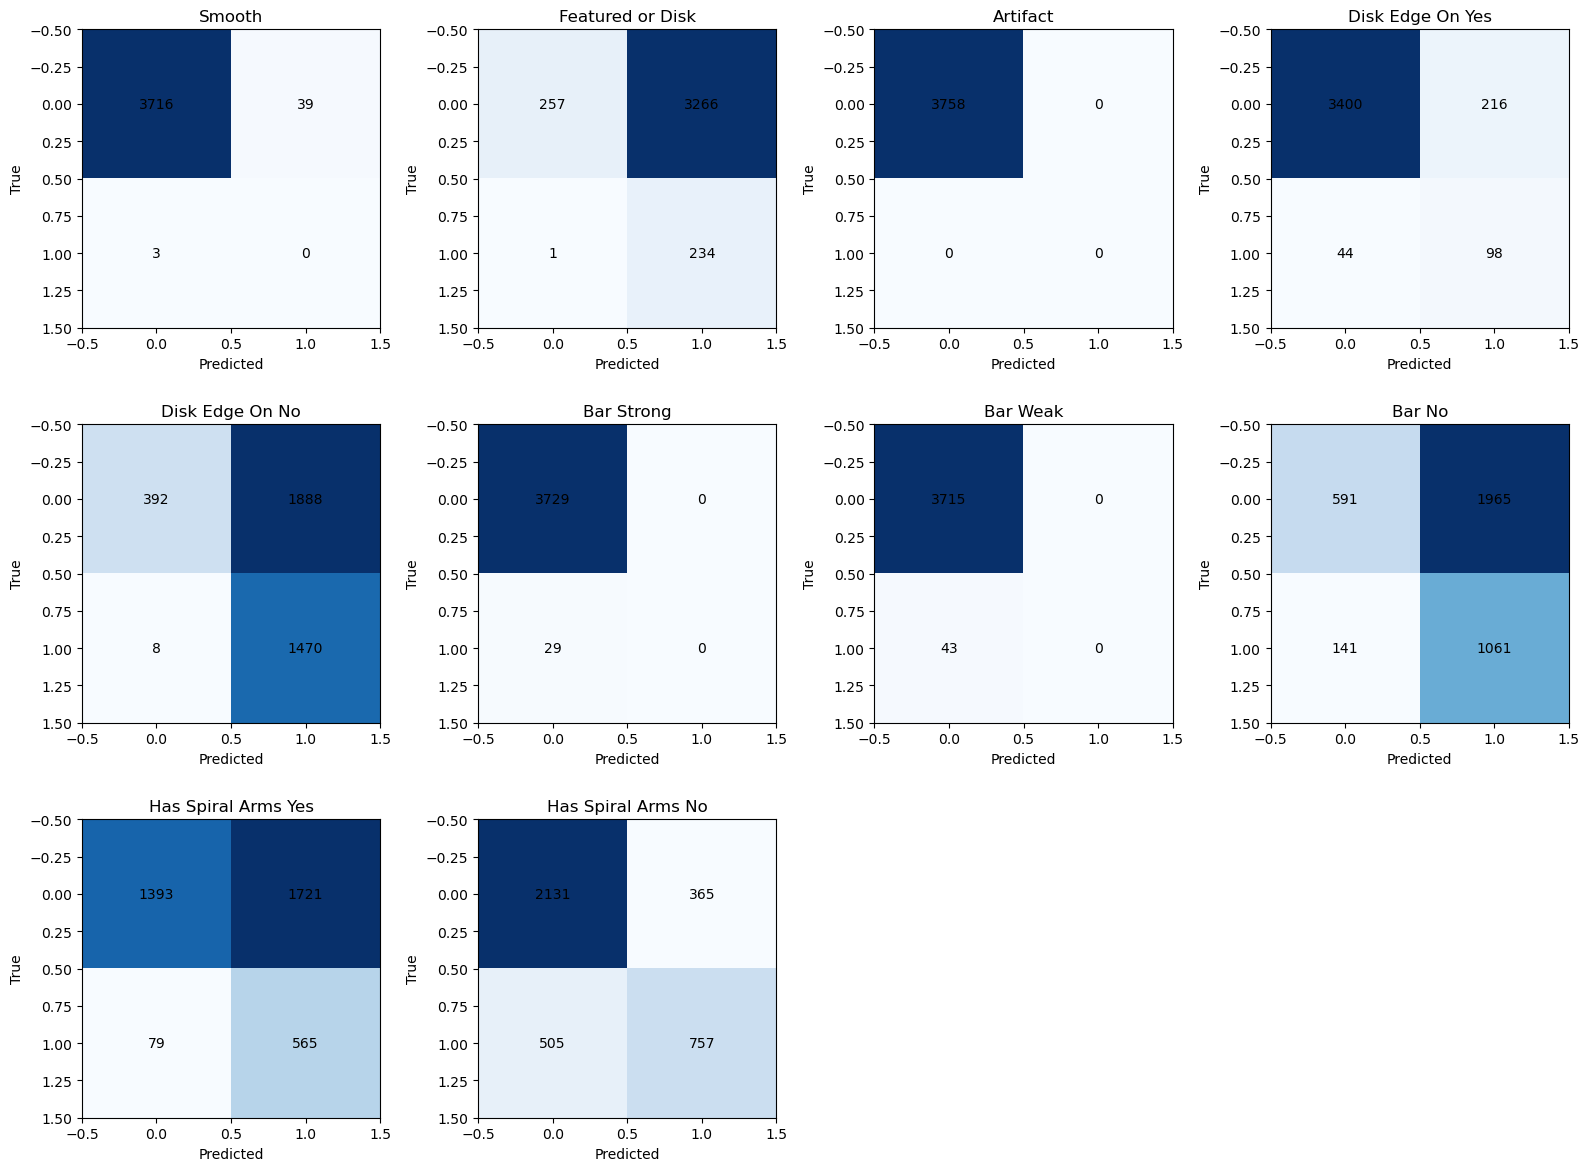

In [154]:
# Visualizing the confusion matrix for each label
def plot_confusion_matrix(confusion_matrices, label_names):
    num_labels = len(confusion_matrices)
    cols = 4
    rows = (num_labels + cols - 1) // cols  # Round up
    
    fig, axes = plt.subplots(rows, cols, figsize = (4 * cols, 4 * rows))
    axes = axes.flatten()

    for i, cm in enumerate(confusion_matrices):
        ax = axes[i]
        im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
        ax.set_title(label_names[i])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

        # Annotate cells
        for (j, k), val in np.ndenumerate(cm):
            ax.text(k, j, f'{val}', ha='center', va='center', fontsize=10)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Define label names for the confusion matrix
label_names = [
    'Smooth', 
    'Featured or Disk', 
    'Artifact', 
    'Disk Edge On Yes', 
    'Disk Edge On No', 
    'Bar Strong', 
    'Bar Weak', 
    'Bar No',
    'Has Spiral Arms Yes',
    'Has Spiral Arms No'
]

# Plot the confusion matrix 
plot_confusion_matrix(metrics[1], label_names)

In [155]:
# Saving the model
model_save_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models'

In [156]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model checkpoint
model_path = os.path.join(model_save_path, f"lit_galaxy_model_{timestamp}_5.ckpt")
trainer.save_checkpoint(model_path)
print(f"✅ Model saved to: {model_path}")

# Save evaluation metrics
metrics_path = os.path.join(model_save_path, f"metrics_{timestamp}_5.json")
with open(metrics_path, "w") as f:
    json.dump(metrics[0], f, indent = 4)
print(f"✅ Metrics saved to: {metrics_path}")

✅ Model saved to: /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models/lit_galaxy_model_20250606_111944_5.ckpt
✅ Metrics saved to: /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models/metrics_20250606_111944_5.json


## Loading model

In [24]:
# Loading model 
model_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models'
model_name = 'lit_galaxy_model_20250606_111944_5.ckpt'

lit_model_loaded = LitGalaxyModel.load_from_checkpoint(os.path.join(model_path, model_name), model = SimpleCNN(num_outputs = len(label_cols)), criterion = nn.BCEWithLogitsLoss())

In [25]:
# Getting the metrics
metrics_name = 'metrics_20250606_111944_5.json'

with open(os.path.join(model_path, metrics_name), "r") as f:
    loaded_metrics = json.load(f)

In [68]:
df_val.loc[df_val['iauname'] == 'J024445.41-080950.9', 'full_image_path']

# Printing path 
print(f"Path for the validation image: {df_val.loc[df_val['iauname'] == 'J024445.41-080950.9', 'full_image_path'].values[0]}")

Path for the validation image: /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/gz_decals_dr5_png_part1/J024/J024445.41-080950.9.png


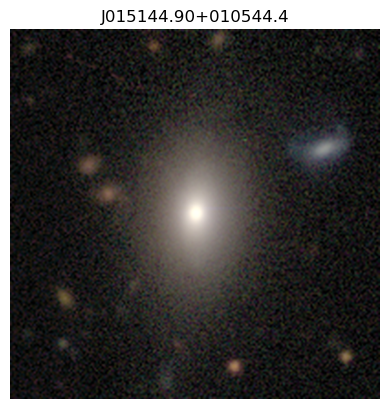

smooth-or-featured_featured-or-disk: Predicted ✅, True ❌
smooth-or-featured_artifact: Predicted ❌, True 🔷
disk-edge-on_no: Predicted ✅, True ❌
bar_strong: Predicted ❌, True 🔷
bar_no: Predicted ✅, True ❌
has-spiral-arms_no: Predicted ✅, True ❌

--- Loaded Model Metrics ---
accuracy: 0.0319
precision_macro: 0.2089
recall_macro: 0.5040
f1_macro: 0.2686
f1_micro: 0.4480


In [77]:
# Galaxy to visualize
name = 'J015144.90+010544.4'
match = df_val[df_val['iauname'] == name]

if match.empty:
    print(f"Galaxy with iauname '{name}' not found in df_val.")
else:
    # Load original image from disk
    image_path = match['full_image_path'].values[0]
    original_image = Image.open(image_path).convert('RGB')

    # Define the same transform used in your dataset (must match training)
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Fix image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # For RGB images
                    ])

    # Transform for model input
    image_tensor = transform(original_image)

    # Ground truth labels from df_val (assumes binary columns for each label)
    true_labels = torch.tensor(match[label_cols].values[0].astype(np.float32))

    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lit_model_loaded = lit_model_loaded.to(device)
    image_batch = image_tensor.unsqueeze(0).to(device)

    # Model prediction
    lit_model_loaded.eval()
    with torch.no_grad():
        output = lit_model_loaded(image_batch)
        probs = torch.sigmoid(output).squeeze(0).cpu().numpy()
        pred_labels = (probs >= 0.5).astype(int)

    # Plot original image
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(name)
    plt.show()

    # Print predictions vs. truth
    for label, pred, true in zip(label_cols, pred_labels, true_labels.numpy().astype(int)):
        if pred == 1 or true == 1:
            print(f"{label}: Predicted {'✅' if pred == 1 else '❌'}, True {'🔷' if true == 1 else '❌'}")

    # Print model metrics
    print("\n--- Loaded Model Metrics ---")
    for key, value in loaded_metrics.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


In [47]:
# Picking an example from the validation set to visualize predictions
name = 'J024445.41-080950.9'
matches = df_val[df_val['iauname'] == name]

if not matches.empty:
    corresponding_idx = matches.index[0]
    idx = corresponding_idx
    image, true_labels = val_dataset[idx]
else:
    print(f"Galaxy with iauname '{name}' not found in df_val.")

# Move image to batch form and same device as model
image_batch = image.unsqueeze(0).to(lit_model.device)

# Get predictions
lit_model.eval()
with torch.no_grad():
    output = lit_model(image_batch)
    probs = torch.sigmoid(output).squeeze(0).cpu().numpy()
    pred_labels = (probs >= 0.5).astype(int)

def prepare_image_for_plotting(image_tensor):
    """
    Unnormalizes and prepares an image tensor (C x H x W) for matplotlib display.
    Assumes normalization with mean=0.5 and std=0.5 for each channel (i.e., x_norm = (x - 0.5) / 0.5).
    """
    # Unnormalize
    img = image_tensor * 0.5 + 0.5  # Inverse of (x - 0.5) / 0.5
    img = torch.clamp(img, 0, 1)   # Ensure values are in [0, 1]
    return img.permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC

# Plot the image
plt.imshow(prepare_image_for_plotting(image))
plt.axis('off')
plt.title(f"{matches['iauname'].values[0]}")
plt.show()

for label, pred, true in zip(label_cols, pred_labels, true_labels.cpu().numpy().astype(int)):
    if pred == 1 or true == 1:
        print(f"{label}: Predicted {'✅' if pred == 1 else '❌'}, True {'🔷' if true == 1 else '❌'}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/gz_decals_dr5_png_part1/J024445.41-080950.9.png'

<b>Comment</b>: The model correctly predicts one of the labels, but also predict one extra label that isn't present in the ground truth - i.e., a false positive. It is a reasonable good prediction. 

In [217]:
def visualize_predictions(model, dataset, label_cols, num_samples=6):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    rows = (num_samples + 2) // 3
    plt.figure(figsize=(15, 5 * rows))

    for i, idx in enumerate(indices):
        image, true_labels = dataset[idx]
        image_batch = image.unsqueeze(0).to(model.device)

        with torch.no_grad():
            outputs = model(image_batch)
            probs = torch.sigmoid(outputs).squeeze(0).cpu().numpy()
            pred_labels = (probs >= 0.5).astype(int)                                    # Apply sigmoid activation and threshold at 0.5 to get binary predictions for each label independently - the threshold can be adjusted based on the problem and the distribution of labels

        true_labels = true_labels.numpy().astype(int)

        # Predicted and true labels as lists
        predicted = [f"- {label}" for label, val in zip(label_cols, pred_labels) if val == 1]
        actual = [f"- {label}" for label, val in zip(label_cols, true_labels) if val == 1]

        pred_str = "\n".join(predicted) if predicted else "None"
        true_str = "\n".join(actual) if actual else "None"

        # Writing galaxy name on each image
        galaxy_name = dataset.df['iauname'].iloc[idx] if hasattr(dataset, 'df') else f"Galaxy {idx}"

        # Plotting
        ax = plt.subplot(rows, 3, i + 1)
        ax.imshow(prepare_image_for_plotting(image))
        ax.axis("off")

        # Display labels below image
        ax_text = f"Predicted:\n{pred_str}\n\nTrue:\n{true_str} \n\n{galaxy_name}"
        ax.set_title(ax_text, fontsize=10, loc='left')

    plt.tight_layout()
    plt.show()

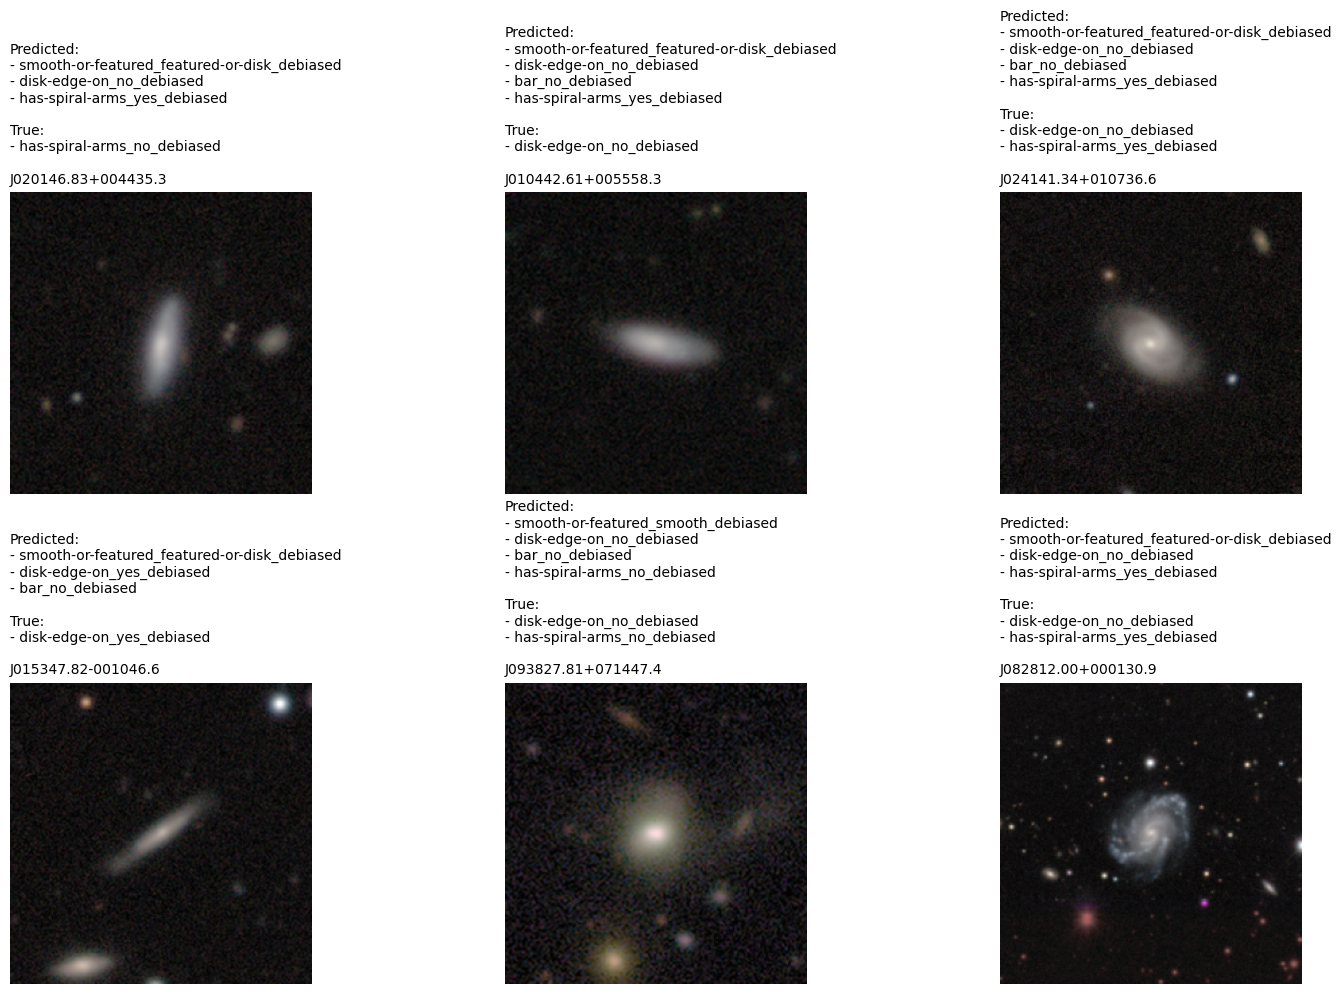

In [239]:
visualize_predictions(lit_model, val_dataset, label_cols);